In [1]:
import sys
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, color, img_as_ubyte

%matplotlib inline

# Getting the images compressed file from Google Drive and extracting

In [2]:
# !pip install gdown

In [3]:
# !gdown -O ../../datasets/ebay_boys_girls_shirts.tar.gz "https://drive.google.com/uc?id=14SgVvj6k12yXDJ82Qz4TdnqaaOBFjZj0"

In [4]:
# import tarfile
# with tarfile.open('../../datasets/ebay_boys_girls_shirts.tar.gz', "r:gz") as tar:
#     tar.extractall('../../datasets/')

# Once the images are extracted in `datasets` folder

In [5]:
def check_mem():
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    print(sorted([(x, sys.getsizeof(globals().get(x))) for x in globals() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True))

def get_file_list(df, folder, n_sample = None, seed = None):
    if n_sample is None:
        file_ids_list = df.file_id.values
    else:
        file_ids_list = df.sample(n = n_sample, random_state = seed).file_id.values
    files_list = [folder + '/' + str(file_id) + '.jpg' for file_id in file_ids_list]
    return files_list

def read_image_and_resize(f, w = 100, h = 100):
    img = plt.imread(f)
    img = transform.resize(img, (w, h), mode='constant', anti_aliasing=True)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        img = img_as_ubyte(img)
    img = color.gray2rgb(img)
    img = img[np.newaxis, :, :, :3]
    if img.shape != (1, 100, 100, 3):
        raise ValueError(f + str(img.shape))
    return img

def read_images_4d_array(files_list):
    images_list = [read_image_and_resize(file) for file in files_list]
    images_array = np.concatenate(images_list)
    return images_array

def get_images_matrix(csv_file, folder, n = None, seed = 1976):
    df = pd.read_csv(csv_file)
    files_list = get_file_list(df, folder, n, seed)
    images = read_images_4d_array(files_list)
    return images

def get_all_pixels(x):
    return x.reshape(-1, np.prod(x.shape[1:]))

def get_final_matrices(n_train = None, n_test = None):
    folder = '../../datasets/ebay_boys_girls_shirts/'
    x_boys_train = get_images_matrix(folder + 'boys_train.csv', folder + 'boys', n_train)
    x_boys_test = get_images_matrix(folder + 'boys_test.csv', folder + 'boys', n_test)
    x_girls_train = get_images_matrix(folder + 'girls_train.csv', folder + 'girls', n_train)
    x_girls_test = get_images_matrix(folder + 'girls_test.csv', folder + 'girls', n_test)
    
    x_boys_train_all = get_all_pixels(x_boys_train)
    x_boys_test_all = get_all_pixels(x_boys_test)
    x_girls_train_all = get_all_pixels(x_girls_train)
    x_girls_test_all = get_all_pixels(x_girls_test)

    x_train = np.vstack([x_boys_train_all, x_girls_train_all])
    x_test = np.vstack([x_boys_test_all, x_girls_test_all])

    y_boys_train = np.array([0] * x_boys_train.shape[0])
    y_boys_test = np.array([0] * x_boys_test.shape[0])
    y_girls_train = np.array([1] * x_girls_train.shape[0])
    y_girls_test = np.array([1] * x_girls_test.shape[0])
    y_train = np.concatenate([y_boys_train, y_girls_train])
    y_test = np.concatenate([y_boys_test, y_girls_test])
    
    return x_train, x_test, y_train, y_test

## Load 10% of data

In [6]:
x_train, x_test, y_train, y_test = get_final_matrices(n_train = 1000, n_test = 250)

In [7]:
print('x_train shape: %d rows, %d columns' % x_train.shape)
print('x_test shape: %d rows, %d columns' % x_test.shape)
print('y_train length: %d' % len(y_train))
print('y_test length: %d' % len(y_test))

x_train shape: 2000 rows, 30000 columns
x_test shape: 500 rows, 30000 columns
y_train length: 2000
y_test length: 500


In [8]:
check_mem()

[('x_train', 60000112), ('x_test', 15000112), ('y_train', 16096), ('y_test', 4096), ('img_as_ubyte', 136), ('check_mem', 136), ('get_file_list', 136), ('read_image_and_resize', 136), ('read_images_4d_array', 136), ('get_images_matrix', 136), ('get_all_pixels', 136), ('get_final_matrices', 136), ('pd', 80), ('np', 80), ('plt', 80), ('transform', 80), ('color', 80)]


Our data matrices aren't that large because their `dtype` is unsigned int and we only took 10% of data:

In [9]:
print(x_train.dtype)

uint8


It's best to turn it to `float` in the 0-1 range, the size should still be OK (or you'll need to add more memory to your Docker/Azure machine):

In [10]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [11]:
check_mem()

[('x_train', 240000112), ('x_test', 60000112), ('y_train', 16096), ('y_test', 4096), ('img_as_ubyte', 136), ('check_mem', 136), ('get_file_list', 136), ('read_image_and_resize', 136), ('read_images_4d_array', 136), ('get_images_matrix', 136), ('get_all_pixels', 136), ('get_final_matrices', 136), ('pd', 80), ('np', 80), ('plt', 80), ('transform', 80), ('color', 80)]


## PCA

In [12]:
from sklearn.decomposition import PCA

x_train_centered = x_train - x_train.mean(axis = 0)
x_test_centered = x_test - x_train.mean(axis = 0) # notice we use x_train means

pca = PCA(n_components = 100)

pca.fit(x_train_centered)
W = pca.components_

x_train_reduced = np.matmul(x_train_centered, W.T)
x_test_reduced = np.matmul(x_test_centered, W.T)

print('x_train_reduced shape: %d rows, %d columns' % x_train_reduced.shape)

x_train_reduced shape: 2000 rows, 100 columns


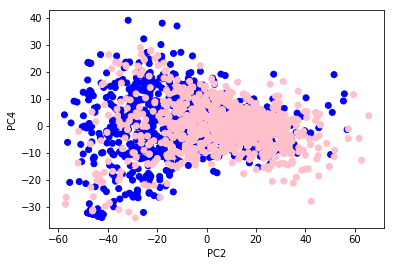

In [13]:
plt.scatter(x_train_reduced[:,1], x_train_reduced[:,3], color=['blue' for i in range(1000)] + ['pink' for i in range(1000)])
plt.xlabel('PC2')
plt.ylabel('PC4')
plt.show()

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

mod = LogisticRegression(solver='lbfgs')
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Accuracy of LR on all pixels: %.2f' % acc)

Accuracy of LR on all pixels: 0.63


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [15]:
mod = LogisticRegression(solver='lbfgs')
mod.fit(x_train_reduced, y_train)
acc = mod.score(x_test_reduced, y_test)
print('Accuracy of LR on first 100 PCs: %.2f' % acc)

Accuracy of LR on first 100 PCs: 0.71


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Classification Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier

mod = DecisionTreeClassifier()
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Accuracy of CART on all pixels: %.2f' % acc)

Accuracy of CART on all pixels: 0.66


In [17]:
mod = DecisionTreeClassifier()
mod.fit(x_train_reduced, y_train)
acc = mod.score(x_test_reduced, y_test)
print('Accuracy of CART on first 100 PCs: %.2f' % acc)

Accuracy of CART on first 100 PCs: 0.64


## Random Forests

In [18]:
from sklearn.ensemble import RandomForestClassifier

mod = RandomForestClassifier(n_estimators = 100)
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Accuracy of RF on all pixels: %.2f' % acc)

Accuracy of RF on all pixels: 0.75


In [19]:
mod = RandomForestClassifier(n_estimators = 100)
mod.fit(x_train_reduced, y_train)
acc = mod.score(x_test_reduced, y_test)
print('Accuracy of RF on first 100 PCs: %.2f' % acc)

Accuracy of RF on first 100 PCs: 0.74


## Boosting Trees

In [20]:
from sklearn.ensemble import GradientBoostingClassifier

mod = GradientBoostingClassifier(n_estimators = 100)
mod.fit(x_train, y_train)
acc = mod.score(x_test, y_test)
print('Accuracy of Boosting on all pixels: %.2f' % acc)

Accuracy of Boosting on all pixels: 0.77


In [21]:
mod = GradientBoostingClassifier(n_estimators = 100)
mod.fit(x_train_reduced, y_train)
acc = mod.score(x_test_reduced, y_test)
print('Accuracy of Boosting on first 100 PCs: %.2f' % acc)

Accuracy of Boosting on first 100 PCs: 0.72
